File where code is written, tested, and integrated. \
Middlebury Stereo Datasets: https://vision.middlebury.edu/stereo/data/

In [1]:
import cv2
import numpy as np
import sklearn 
import igraph
import matplotlib.pyplot as plt

In [2]:
class Configuration:
    def __init__(self, size, max_disparity):
        self.size = size
        self.max_disparity = max_disparity
        self.config_map = np.zeros((size[0]* size[1], max_disparity))


In [17]:
class Energy:
    def __init__(self):
        self.graph = None
        self.a_to_id = {}
        self.id_to_a = ['source', 'sink']
        self.Econst = 0
        self.Gconst = 0
        #igraph requires "preprocessing" to initialize edge with weights
        #see https://igraph.org/python/doc/tutorial/generation.html "From nodes to edges" for more detail
        self.vertex_num = 2 # source vertex:0, terminal vertex:1
        self.edges = []
        self.capacity = []

    def get_node_id(self, x)->int: 
        return self.a_to_id[x]
    
    # Add a new binary variable as a node
    def add_node(self, x, E0=0, E1=0)->int:
        x_id = self.vertex_num
        self.a_to_id[x] = x_id
        self.id_to_a.append(x)
        self.vertex_num += 1
        self.add_term1(x_id, E0,E1)
        return x_id

    # Add a constant to the energy function
    def add_constant(self, E)->None:
        self.Gconst += E
        return

    # Add a term E(x) of one binary variable to the energy function,
    # where E(0) = E0, E(1) = E1. E0 and E1 can be arbitrary.
    def add_term1(self, x_id, E0, E1)->None:
        self.edges.extend(([0,x_id], [x_id,1]))
        if(E0 > E1):
            self.capacity.extend((0, E0-E1))
        else:
            self.capacity.extend((E1-E0, 0))
        self.add_constant(np.min((E0,E1)))
        return
    
    # Add a  term E(x, y) of two binary variables to the energy function,
    # where E(0, 0) = A, E(0, 1) = B, E(1, 0) = C, E(1, 1) = D.
    # The term must be regular, i.e. E00 + E11 <= E01 + E10
    def add_term2(self, x_id, y_id, E00, E01, E10, E11)->None:
        # E = A B = B B + A-B 0 +    0    0
        #     C D   D D   A-B 0   B+C-A-D 0
        self.add_term1(x_id, E01, E11)
        self.add_term1(y_id, E00 - E01, 0)
        self.edges.extend(([x_id, y_id], [y_id, x_id]))
        self.capacity.extend((0, E01 + E10 - E00 - E11))
        return

    # Forbid (x, y) = (0, 1) by putting infinite value to
    # the edge from x to y
    def forbid01(self, x_id, y_id)->None:
        self.edges.extend(([x_id, y_id], [y_id, x_id]))
        self.capacity.extend((np.inf, 0))
        return
    
    def minimize(self)->int:
        self.graph = igraph.Graph(
            n = self.vertex_num,
            edges = self.edges,
            edge_attrs={'weight':self.capacity,
                        'label':self.capacity,
                        'curved': np.ones_like(self.capacity)},
            vertex_attrs={'label':self.id_to_a},
            directed = True
        )
        print("self.capacity",self.capacity)
        print("self.edges",self.edges)
        self.mincut = self.graph.mincut(source = 0, target = 1, capacity="weight")
        print("self.mincut.value",self.mincut.value)
        print("self.Econst",self.Econst)
        return self.mincut.value + self.Gconst
    
    def visualize(self):
        visual_style = {}
        out_name = "graph.png"
        # Set bbox and margin
        visual_style["bbox"] = (400,400)
        visual_style["margin"] = 27
        # Set vertex colours
        visual_style["vertex_color"] = 'white'
        # Set vertex size
        visual_style["vertex_size"] = 45
        # Set vertex lable size
        visual_style["vertex_label_size"] = 22
        # # Don't curve the edges
        visual_style["edge_curved"] = False
        # Set the layout
        my_layout = self.graph.layout_lgl()
        visual_style["layout"] = my_layout
        # Plot the graph
        return(igraph.plot(self.graph, **visual_style))

In [18]:
e = Energy()
#E(x, y, z) = x - 2*y + 3*(1-z) - 4*x*y + 5*|y-z|
x = e.add_node('x')
y = e.add_node('y')
z = e.add_node('z')

e.add_term1(x, 0, 1)
e.add_term1(y, 0, -2)
e.add_term1(z, 3, 0)

e.add_term2(x, y, 0, 0, 0, -4)
e.add_term2(y, z, 0, 5, 5, 0)
e.minimize()

self.capacity [0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 3, 0, 4, 0, 0, 0, 4, 0, 5, 5, 0, 0, 10]
self.edges [[0, 2], [2, 1], [0, 3], [3, 1], [0, 4], [4, 1], [0, 2], [2, 1], [0, 3], [3, 1], [0, 4], [4, 1], [0, 2], [2, 1], [0, 3], [3, 1], [2, 3], [3, 2], [0, 3], [3, 1], [0, 4], [4, 1], [3, 4], [4, 3]]
self.mincut.value 6.0
self.Econst 0


-5.0

In [11]:
print(e.graph.es['weight'])

[0, 0, 1, 0]


In [112]:
print(e.mincut.partition)

[[0, 2, 3, 4], [1]]


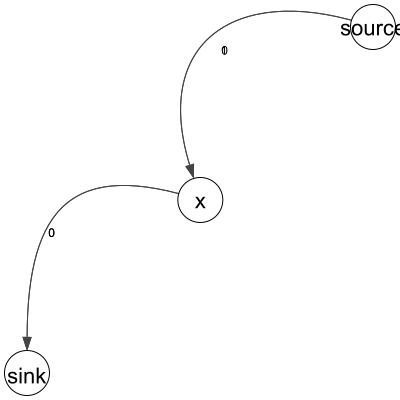

In [119]:
e.visualize()